# Importing Log Data

In [25]:
import pandas as pd

logs = pd.read_csv('data/labeled_data/2class_undersample_masked.csv')

In [18]:
logs.columns

Index(['text', 'label'], dtype='object')

In [26]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder() #target is 0

logs['label'] = encoder.fit_transform(logs['label'])

In [27]:
logs['label'].value_counts()

label
0    2982
1    2982
Name: count, dtype: int64

In [28]:
#split the logs into train/test

from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(logs['text'], logs['label'], test_size=0.2, random_state=42)

### Building DataLoaders with Log Files

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# BERT

In [30]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [4]:
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")

Generating test split: 100%|██████████| 50000/50000 [00:00<00:00, 582435.44 examples/s]


In [38]:
data_set_train = dataset['train'].shuffle(seed=42).select(range(5000))
data_set_test = dataset['test'].shuffle(seed=42).select(range(5000))

In [34]:
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]
            max_length = 512, # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [41]:
y_train.to_numpy()

array([1, 1, 1, ..., 1, 1, 1])

In [35]:
xtrain_inputs, xtrain_masks = preprocessing_for_bert(X_train)
xval_inputs, xval_masks = preprocessing_for_bert(X_val)
ytrain_labels = torch.tensor(y_train.to_numpy())
yval_labels = torch.tensor(y_val.to_numpy())

c:\Users\Abhay\Documents\SMU\Term 4\CapstoneA\.venv\lib\site-packages\transformers\tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [39]:
train_inputs, train_masks = preprocessing_for_bert(data_set_train['text'])
val_inputs, val_masks = preprocessing_for_bert(data_set_test['text'])
train_labels = torch.tensor(data_set_train['label'])
val_labels = torch.tensor(data_set_test['label'])

c:\Users\Abhay\Documents\SMU\Term 4\CapstoneA\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [21]:
from torch.utils.data import TensorDataset, RandomSampler, DataLoader, SequentialSampler

#Old Dataset Generation

batch_size = 16 #16 or 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [48]:
X_test.shape

(99999,)

In [36]:
from datasets import Dataset
from torch.utils.data import DataLoader

#new Dataset Generation

batch_size =  16

train_dst = Dataset.from_dict({'input_ids': xtrain_inputs, 'attention_mask': xtrain_masks, 'labels': ytrain_labels})
train_dst.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

#train_data = TensorDataset(train_inputs, train_masks, train_labels)
#train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_dst, shuffle = True, batch_size=batch_size)

test_dst = Dataset.from_dict({'input_ids': xval_inputs, 'attention_mask': xval_masks, 'labels': yval_labels})
test_dst.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

val_dataloader = DataLoader(test_dst, shuffle = True, batch_size=batch_size)

In [37]:
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=1e-5)

num_epochs = 15
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [69]:
import gc
del model
torch.cuda.empty_cache()
gc.collect()

494

In [39]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [15]:
device

device(type='cuda')

In [41]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batche = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batche)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

100%|██████████| 3585/3585 [39:47<00:00,  2.16it/s]

In [42]:
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.6429319371727749}

In [15]:
model.save_pretrained('models/Fine-Tuned_UndersampledMasked_2Label_DistilBertModel')

# Gauge performance on Test Set: 

In [43]:
test_inputs, test_masks = preprocessing_for_bert(X)
train_labels = torch.tensor(y.to_numpy())

c:\Users\Abhay\Documents\SMU\Term 4\CapstoneA\.venv\lib\site-packages\transformers\tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [44]:
ftest_dst = Dataset.from_dict({'input_ids': test_inputs, 'attention_mask': test_masks, 'labels': train_labels})
ftest_dst.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

test_dataloader = DataLoader(ftest_dst, shuffle = True, batch_size=batch_size)

In [45]:
import numpy as np

predictions_num = []
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        #import pdb; pdb.set_trace()
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        predictions_num.append(predictions)
        
#predictions_num = np.concatenate(predictions_num).ravel()

In [46]:
preds = torch.cat(predictions_num).cpu().numpy()

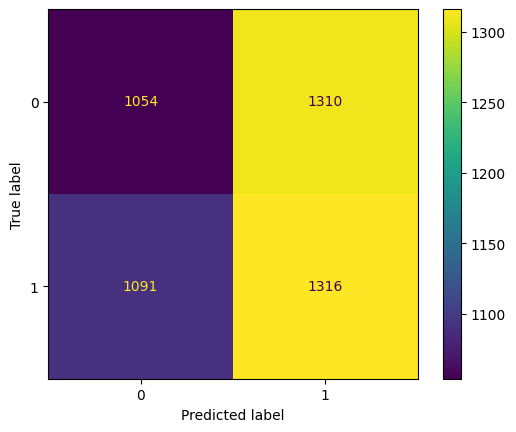

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y, preds)

In [22]:
logs['label'].value_counts() #Model is 0.993 accurate, which is exactly the amount of 0s being mislabelled. 

label
1    497012
0      2982
Name: count, dtype: int64

In [ ]:
# TODO - Assess class imbalance:
# possible methods include curated dataset with 1-2 grouped with undersampling of 3,4 to introduce class size parity